# MATH 405/607 

# Numerical Methods for Differential Equations

[[Instructor: Christoph Ortner]](http://www.math.ubc.ca/~ortner/)  [[CANVAS]](https://canvas.ubc.ca/courses/55324)


## Spectral Methods 2 - Solving IBVPs

* discretisation of (initial) boundary value problems using Fourier spectral methods.


### Literature

* N Trefethen, Spectral Methods in Matlab [[html]](https://people.maths.ox.ac.uk/trefethen/spectral.html)
* https://people.maths.ox.ac.uk/trefethen/pdetext.html, Ch. 7 

In [1]:
include("../math405.jl")

 Activating environment at `~/Documents/UBC/Math/Math 405/math405_2020W/Project.toml`


In [4]:
# Some codes from L11

using FFTW
"construct a real-space grid - use FFT convention"
xgrid(N) = range(0.0, stop=2π-2π/2N, length=2N)
"construct the reciprocal space grid assumed by `fft` - carefully use FFT convention"
kgrid(N) = [0:N; -N+1:-1]
"compute the fourier coefficients of I_N"
fouriercoeffs(f::Function, N) = fouriercoeffs(f.(xgrid(N)))
fouriercoeffs(F::Vector) = fft(F) / length(F)
"evaluate a trigonometric polynomial"
eval_trig(F::Function, N, Z) = eval_trig(fouriercoeffs(F, N), Z)
eval_trig(F̂::Vector, Z) = real(sum( f̂k * exp.((im * k)*Z) for (f̂k, k) in zip(F̂, kgrid(length(F̂)÷2)) ))


┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1278


eval_trig (generic function with 2 methods)

This notebook contains only computational examples. See the recorded lecture for derivation of the implemented methods / some minimal theory. All examples use periodic boundary conditions, i.e., $x \in (-\pi, \pi]$ with $u(-\pi) = u(\pi)$ as well as for all required derivatives. Or, alternatively we can consider the problem to be posed for $x \in \mathbb{R}$ but restricted to periodic solutions.

Since all examples will use PBCs we will not state them explicitly every time.

### Example 1: Stead state diffusion

$$
    - u'' = f  
$$
After transformation to reciprocal space, 
$$
    |k|^2 \hat{u}_k = \hat{f}_k
$$
or, 
$$
    \hat{u}_k = |k|^{-2} \hat{f}_k
$$
The discretisation / approximation occurs due to approximation of the right-hand side via trigonometric interpolant.

The only error we commit here is in the approximation of the $f$. If $f$ is analytic, then we expect an exponential rate.

In [5]:
# method of manufactured solutions!
u = x ->  exp(cos(x)^3) - 7.3256351769886540462/(2*pi)
du = x -> ForwardDiff.derivative(u, x)
f = x -> - ForwardDiff.derivative(du, x)
N = 10
X = xgrid(N)
F = f.(X) 
F̂ = fouriercoeffs(F); F̂[1] = 0   # for stability!
K = kgrid(N)
Û = F̂ ./ (eps() .+ K.^2)    # solution in reciprocal space, eps() is to avoid NaN
U = real.(2*N*ifft(Û));     # solution in terms of nodal values!

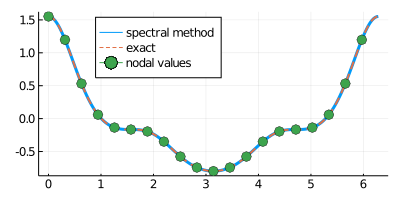

In [6]:
xp = range(0, 2*pi, length=200)
Up = [ real(eval_trig(Û, x)) for x in xp ]   # interpolate in-between nodal values
plot(xp, Up, label = "spectral method", lw = 3, size = (400, 200), legend = :top)
plot!(xp, u.(xp), lw = 2, ls =:dash, label = "exact")
plot!(X, U, ms=5, m = :o, lw=0, label = "nodal values")

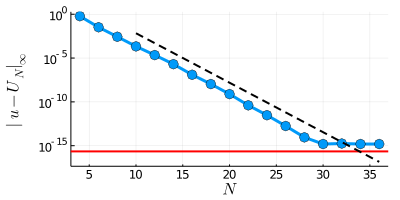

In [7]:
# convergence test 
function solve_ex1(N)
    F̂ = fouriercoeffs(f, N); F̂[1] = 0 
    return F̂ ./ (eps() .+ kgrid(N).^2)
end
NN = 4:2:36 
xe = range(0, 2*pi, length = 10_000) 
ue = u.(xe) # [eval_trig(solve_ex1(64), x) for x in xe]
Err = [ norm(ue - eval_trig.(Ref(solve_ex1(N)), xe), Inf) for N in NN ]
plot(NN, Err, lw=3, ms=5, m=:o, label = "", ylabel = L"\|u - U_N\|_\infty", size = (400, 200), yscale = :log10)
hline!([eps()], lw=2, c=:red, label = "")
plot!(NN[4:end], 3000*exp.(-1.3*NN[4:end]), c=:black, lw=2, ls=:dash, label = "", xlabel = L"N")

### Example 2: Linear, Homogeneous Advection 

$$
    u_t + a u_x = 0 
$$
Transform to reciprocal space
$$
    \partial_t \hat{u}_k + a i k \hat{u}_k = 0 
$$
We can think of this as a Schrödinger equation, which is closely related to hamiltonian systems. In this case we can get a Hamiltonian system by converting to a real and immaginary parts (cf. recorded lecture). We know from A3 that the Crank-Nicholson scheme is a good integrator for linear Hamiltonian systems, so let's use this for the discretisation:
$$
    \frac{\hat{u}_k^{m+1} - \hat{u}_k^m}{\tau} + \frac{a i k}{2} \big( \hat{u}_k^{m+1} + \hat{u}_k^m \big) = 0
$$
or, equivalently, 
$$
    \hat{u}_k^{m+1} = \frac{1 - \tau a i k/2}{1+ \tau aik/2} \hat{u}_k^m
$$
This will conserve $|\hat{u}_k^m|$ *exactly* - hence there will be no artificial dampling!

In [ ]:
N = 6; τ = 1e-2
X = xgrid(N); xp = range(0, 2*pi, length=200)
K = kgrid(N)
u0 = 
U = exp.(- sin.(X).^2) .- exp(-1)
Û = fouriercoeffs(U)
Â = (1 .- im*τ/2 * K) ./ (1 .+ im*τ/2 * K)
@gif for t in τ:τ:5
    Û = Â .* Û
    plot(xp, eval_trig.(Ref(Û), xp), lw=3, label = "", title = "||Û||_2 = $(round(norm(Û), digits=15))", size = (400, 200))
end

### Example 3: Korteweg–de Vries Equation

$$
    u_t + \Big(\frac12 u^2\Big)_x + \epsilon u_{xxx} = 0
$$
Fourier transform to 
$$
    \partial_t \hat{u}_k + \frac{i k}{2} \big(u^2\big)^{\wedge}_k - i \epsilon k^3 \hat{u}_k = 0
$$
Due to the $u_{xxx}$ term the problem is potentially extremely stiff, but we will essentially ignore this here and just "overkill" the time integration.

Another challenge: how do we discretize $\widehat{u^2}$?

If $f, g$ are degree-$N$ trigonometric polynomials then $fg$ will have degree $2N$ and we need to project it back to a degree-$N$ trig poly. A convenient method to achieve this is via trigonometric interpolation:
$$
    (f g)^{\wedge} \approx {\rm DFT}\big[ I_N[f g] \big]
$$


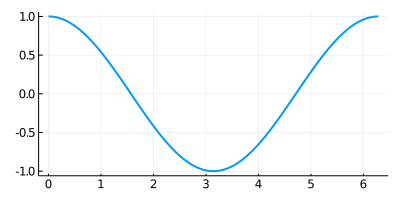

In [8]:
N = 64
X = xgrid(N); K = kgrid(N)
xp = range(0, 2*π, length = 300)
# A = 25; B = 16
# U0 = 2*A^2*sech.(0.5*(A*(X.+(2-π)))).^2 + 2 * B^2*sech.(0.5*(B*(X.+(1-π)))).^2
δ = 0.1
U0 = cos.(X); 
Û0 = fouriercoeffs(U0)
plot(xp, eval_trig.(Ref(Û0), xp), lw = 2, label = "", size = (400, 200))

In [9]:
function kdv1(Û, _p, _t) 
    U = real.(2*N*ifft(Û))
    return δ^2 * im * K.^3 .* Û - im/2 * K .* fouriercoeffs(U.^2)
end
Tf = 10.0; Trange = range(0.0, Tf, length = 500)
soln = solve(ODEProblem(kdv1, Û0, Tf), RK4(), saveat = Trange)
# @show length(soln.t)
;

┌ Info: Saved animation to 
│   fn = /Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/notes/tmp.gif
└ @ Plots /Users/owensheekey/.julia/packages/Plots/shY1Z/src/animation.jl:104


Plots.AnimatedGif("/Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/notes/tmp.gif")
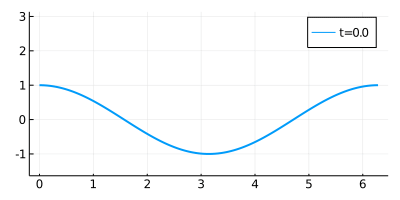

In [10]:
@gif for t in Trange
    Û = soln(t)
    plot(xp, eval_trig.(Ref(Û), xp), lw=2, label = "t=$(round(t, digits=1))", size = (400, 200), ylims=[-1.5, 3]) 
end

In [ ]:
# A travelling wave solution 
N = 128
X = xgrid(N); K = kgrid(N)
xp = range(0, 2*π, length = 600)
A = 25; B = 16
U0 = 2*A^2*sech.(0.5*(A*(sin.(X.+(2-π))))).^2 # + 2 * B^2*sech.(0.5*(B*(X.+(1-π)))).^2
δ = 1.0
Û0 = fouriercoeffs(U0)
plot(xp, eval_trig.(Ref(Û0), xp), lw = 2, label = "", size = (400, 200))

In [ ]:
Tf = 0.006; Trange = range(0.0, Tf, length = 300)
soln = solve(ODEProblem(kdv1, Û0, Tf), RK4(), saveat = Trange)
;

In [ ]:
@gif for t in Trange
    Û = soln(t)
    plot(xp, eval_trig.(Ref(Û), xp), lw=2, label = "t=$(round(t, digits=1))", size = (400, 200), ylims=[-100, 2000]) 
end

In [ ]:
# Looks dodgy? Experimentally check the convergence!!!
N = 256
X = xgrid(N); K = kgrid(N)
A = 25; B = 16
U0 = 2*A^2*sech.(0.5*(A*(sin.(X.+(2-π))))).^2 # + 2 * B^2*sech.(0.5*(B*(X.+(1-π)))).^2
δ = 1.0
Û0 = fouriercoeffs(U0)
soln_256 = solve(ODEProblem(kdv1, Û0, Tf), RK4(), saveat = Trange)
;

In [ ]:
xp = range(0, 2*π, length = 600)
@gif for t in Trange
    Û = soln(t); Û256 = soln_256(t);
    plot(xp, eval_trig.(Ref(Û), xp), lw=2, label = "t=$(round(t, digits=1))", size = (400, 200), ylims=[-100, 1500]) 
    plot!(xp, eval_trig.(Ref(Û256), xp), lw=1, ls = :dash, label = "") 
end

## 2D Examples

Trigonometric polynomials and the DFT can be generalised to $d$ dimension: 
$$
    u({\bf x}) = \sum_{{\bf k} \in \mathbb{Z}^d} \hat{u}_{{\bf k}} e^{i {\bf k} \cdot {\bf x}}
$$
where ${\bf x} = (x_1, \dots, x_d)$, ${\bf k} = (k_1, \dots, k_d)$. We can use this analogously as in the 1D case. I won't give any details here but just show you how to use this.

### Example 4: Laplace equation in 2D

$$
    - u_{xx} - u_{yy} = f, \qquad (x, y) \in (0, 2\pi)^2
$$
with PBCs. We require again that $\int f = 0$.

In [ ]:
# grid parameters: 2π x 2π
N = 2^4          # number of grid points 
h = π/N        # mesh spacing 
# model parameters 
f = (x,y) -> exp(sin(x)*cos(2*y)+0.2*sin(x+y)) # + const -> to be removed below!

# real-space grid 
x = xgrid(N); Xx = kron(x, ones(2*N)'); Xy = Xx'
# reciprocal-space grid
k = kgrid(N); Kx = kron(k, ones(2*N)'); Ky = Kx'

# trigonometric interpolant of f
F = f.(Xx, Xy)
F̂ = fft(F); F̂[1] = 0  # this is a 2D tensor-product FFT!
# solve PDE
Û = F̂ ./ (eps() .+ Kx.^2 + Ky.^2) 
U = real.(ifft(Û))

# plot the solution 
Plots.surface(x, x, U, size = (400, 300))

In [ ]:
# or as a contour plot 
Plots.contour(x, x, U, fill=true, size = (350,300))

### Example 5: 2D Wave Equation 

with constant wave speed
$$
    u_{tt} = u_{xx} + u_{yy}
$$
Spectral discretisation in space: 
$$
    \partial_t^2 \hat{U}_{k_1 k_2} = - (k_1^2 + k_2^2) \hat{U}_{k_1 k_2}
$$
Leapfrog formula in time to conserve energy
$$
    \frac{\hat{U}_{k_1 k_2}^{m+1} - 2 \hat{U}_{k_1 k_2}^m - \hat{U}_{k_1 k_2}^{m-1}}{\tau^2} 
    = - (k_1^2 + k_2^2) \hat{U}_{k_1 k_2}^m
$$



In [ ]:
N = 64
x = xgrid(N); Xx = kron(x, ones(2*N)'); Xy = Xx'
k = kgrid(N); Kx = kron(k, ones(2*N)'); Ky = Kx'
U0 = exp.(-10*(1 .+ cos.(Xx))) .* exp.(-10*(1 .+ cos.(Xy)))
Û0 = fft(U0)
Û1 = Û0  # zero initial velocity 
dt = 0.2 / N 
@gif for n = 1:4_000
    Û0, Û1 = Û1, 2 * Û1 - Û0 - dt^2 * (Kx.^2 + Ky.^2) .* Û1 
    Plots.surface(x, x, real.(ifft(Û1)), zlims = [-0.3, 0.3], color=:viridis)
end every 5

### Example 6: Cahn--Hilliard equation

$$ 
    (-\Delta)^{-1} u_t = \epsilon \Delta u - \frac{1}{\epsilon} (u^3 - u) 
$$
The difficulty here is that a trivial semi-implicit time discretisation
$$
    u^{(n+1)} + \epsilon \tau \Delta^2 u^{(n+1)} = u^{(n)} + \frac{\tau}{\epsilon} \Delta (u^3 - u)
$$
has time-step restriction $O( \epsilon h^2 )$. We can stabilise with a (local) convex-concave splitting such as
$$
    (1 + \epsilon \tau \Delta^2 - C \tau \Delta) u^{(n+1)}
    = (1-C \tau \Delta) u^{(n)} + \frac{\tau}{\epsilon} \Delta (u^3 - u)^{(n)}.
$$
Since $(u^3-u)' = 3 u^2 - 1 \in [-1, 2]$ so we need $C \geq 2/\epsilon$ to get $\tau$-independent stability. 
We then choose the time-step $\tau = h \epsilon$ to make up for the loss of accuracy.

In reciprocal space, the time step equation becomes
$$
    (1+\epsilon \tau |k|^4 + C \tau |k|^2) \hat{u}^{(n+1)} = \big(1+C\tau |k|^2 + \frac{\tau}{\epsilon} |k|^2\big) \hat{u}^{(n)} - \frac{\tau}{\epsilon} |k|^2 (\widehat{u^3})^{(n)},
$$
(For something more serious we should probably implement a decent adaptive time-stepping strategy.)

In [ ]:
# grid parameters: 2π x 2π
N = 2^6          # number of grid points 
h = π/N        # mesh spacing 
# model parameters 
ϵ = h * 3        # interface thickness 
C = 2/ϵ          # stabilisation parameter
τ = ϵ * h        # time-step 
Tfinal = 10      # final time 

# real-space and reciprocal-space grids
x = xgrid(N)
k = kgrid(N)
# Δ multiplier
Δ = -kron(k.^2, ones(2*N)') .- kron(ones(2*N), k'.^2)

# initial condition
u = rand(2*N, 2*N)  .- 0.5

# time-stepping loop
@gif for n = 1:ceil(Tfinal / τ)
    global u 
    f̂ = (1 .- C*τ*Δ) .* fft(u) + τ/ϵ * (Δ .* fft(u.^3-u))
    u = real(ifft( f̂ ./ (1 .+ ϵ*τ*Δ.^2 - C*τ*Δ) ))
    contour(x, x, u, fill=true, lw=0, color=:thermal)
end every 5

In [ ]:
# INCOMPLETE CODE - PLEASE IGNORE
# function solve_laplace2D(N, f, xerr) 
#     x = xgrid(N); Xx = kron(x, ones(2*N)'); Xy = Xx'
#     k = kgrid(N); Kx = kron(k, ones(2*N)'); Ky = Kx'
#     F̂ = fft(f.(Xx, Xy));  F̂[1] = 0 
#     Û = F̂ ./ (eps() .+ Kx.^2 + Ky.^2)
#     u = [ sum(û * exp(im * (kx*x+ky*y)) for (û, kx, ky) in zip(Û, Kx, Ky))
#           for x in xerr, y in xerr ]
#     return u
# end
# NN = (2).^(3:8)